#### Using ARIMAX model to forecast new vaccinations in a given day

The following notebook uses a previously processed dataset called "us_series" containing time series information on vaccinations, COVID-19 cases, government restrictions, and mobility (visits to places in community) in the United States. 

#### Data Citation: 

{
Wahltinez2020,
  author = "O. Wahltinez and others",
  year = 2020,
  title = "COVID-19 Open-Data: curating a fine-grained, global-scale data repository for SARS-CoV-2",
  note = "Work in progress",
  url = {https://goo.gle/covid-19-open-data}
}

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX # has the capability of arimax
from statsmodels.tsa.stattools import adfuller
import itertools
import statsmodels.api as sm
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings("ignore")

Find what variables have a notable correlation with new_persons_vaccinated:

In [244]:
predictor_columns = ['new_persons_vaccinated', 'new_deceased', 'new_confirmed', 'cumulative_confirmed', 'cumulative_deceased', 
                     'school_closing', 'workplace_closing', 'cancel_public_events', 'restrictions_on_gatherings', 
                     'public_transport_closing', 'stay_at_home_requirements', 'restrictions_on_internal_movement', 
                     'international_travel_controls', 'income_support', 'debt_relief', 'fiscal_measures', 
                     'international_support', 'public_information_campaigns', 'testing_policy', 'contact_tracing', 
                     'emergency_investment_in_healthcare', 'investment_in_vaccines', 'facial_coverings', 
                     'vaccination_policy', 'stringency_index', 'mobility_retail_and_recreation', 
                     'mobility_grocery_and_pharmacy', 'mobility_parks', 'mobility_transit_stations', 
                     'mobility_workplaces', 'mobility_residential']

# Calculating correlation matrix
correlation_matrix = us_series[predictor_columns].corr()

# Find variables with a correlation above the threshold with the target variable
highly_correlated_vars = correlation_matrix[correlation_matrix['new_persons_vaccinated'].abs() > 0.25]['new_persons_vaccinated']

# Remove the target variable itself from the list
highly_correlated_vars = highly_correlated_vars.drop('new_persons_vaccinated')

# Display the variables with correlations above the threshold
print(f"Variables with correlation above {0.25} with '{'new_persons_vaccinated'}':")
print(highly_correlated_vars)

Variables with correlation above 0.25 with 'new_persons_vaccinated':
cumulative_confirmed        -0.580457
cumulative_deceased         -0.574902
mobility_transit_stations   -0.329584
mobility_residential         0.338504
Name: new_persons_vaccinated, dtype: float64


The above variables are the predictors to include (as of now) when predicting new_persons_vaccinated

In [203]:
# change date and index to a suitable format for ARIMAX
us_series.index = pd.to_datetime(us_series['date'])
us_series = us_series[~us_series.index.duplicated()]  # just in case there are duplicates
us_series = us_series.reindex(pd.date_range(start=us_series.index.min(), end=us_series.index.max(), freq='D'))

I will check if seasonal patterns exist in vaccination rates because that will indicate whether or not I should use ARIMAX or SARIMAX, which includes the seasonality component. To check, I will simply make a time-series plot and look for a pattern.

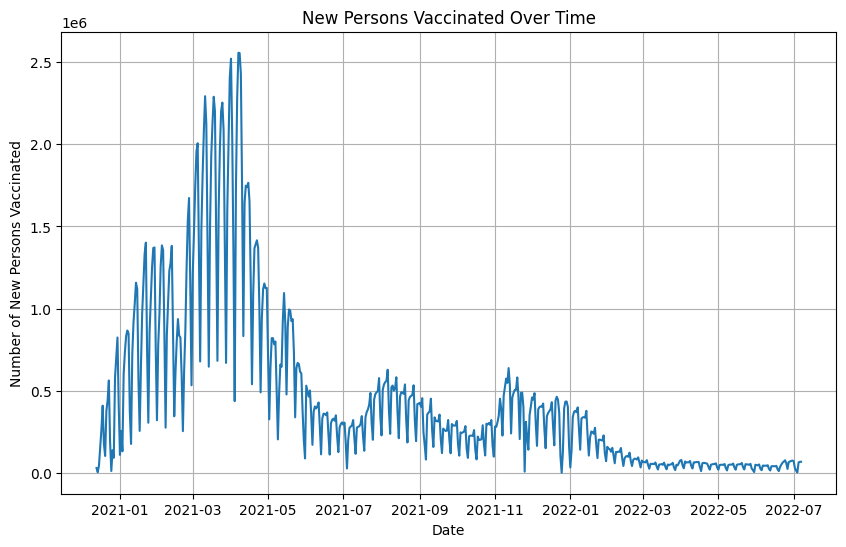

In [212]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
plt.plot(us_series['new_persons_vaccinated'])
plt.title('New Persons Vaccinated Over Time')
plt.xlabel('Date')
plt.ylabel('Number of New Persons Vaccinated')
plt.grid(True)
plt.show()

Appears to not have much seasonality, so use ARIMAX.

I will use an 80/20 split for the model, meaning I will train the model on 80% of the data, and test it on the remaining 20%.

In [211]:
# set target variable and exogenous variables
target_var = 'new_persons_vaccinated'
exo_vars = ['cumulative_confirmed', 'cumulative_deceased', 'mobility_transit_stations', 'mobility_residential']

# Train-test split
train_size = int(len(us_series) * 0.8)
train_data, test_data = us_series.iloc[:train_size], us_series.iloc[train_size:]

To correctly run and interpret an ARIMAX model, the data should be stationary. To check the stationarity of the data, I will use the augmented Dickey–Fuller test. 

In [254]:
# function to check stationarity
def check_stationary(data, var):
    result = adfuller(data[var])
    print(var + ' STATIONARY TEST:')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

In [255]:
# check stationarity of all variables involved in the model
check_stationary(us_series, target_var)
check_stationary(us_series, exo_vars[0])
check_stationary(us_series, exo_vars[1])
check_stationary(us_series, exo_vars[2])
check_stationary(us_series, exo_vars[3])

new_persons_vaccinated STATIONARY TEST:
ADF Statistic: -1.4716098365290051
p-value: 0.547505901237589
Critical Values: {'1%': -3.4421660928041633, '5%': -2.8667523104859627, '10%': -2.56954599309042}
cumulative_confirmed STATIONARY TEST:
ADF Statistic: 0.2331026993699244
p-value: 0.9740582926408712
Critical Values: {'1%': -3.4422521197633187, '5%': -2.866790184232015, '10%': -2.569566175304558}
cumulative_deceased STATIONARY TEST:
ADF Statistic: -0.8214662842243922
p-value: 0.8127350476717949
Critical Values: {'1%': -3.4422521197633187, '5%': -2.866790184232015, '10%': -2.569566175304558}
mobility_transit_stations STATIONARY TEST:
ADF Statistic: -2.0506603944934327
p-value: 0.2648111597958526
Critical Values: {'1%': -3.4421447800270673, '5%': -2.8667429272780858, '10%': -2.5695409929766093}
mobility_residential STATIONARY TEST:
ADF Statistic: -2.797936748168882
p-value: 0.058569093848956484
Critical Values: {'1%': -3.4421660928041633, '5%': -2.8667523104859627, '10%': -2.56954599309042

All variables appear to be at least somewhat non-stationary so they need to be manipulated before performing ARIMAX using the differencing strategy.

In [249]:
# Make a copy of the DataFrame
stationary_us_series = us_series.copy()

# Differencing the target variable
stationary_us_series['diff_new_vaccinated_persons'] = stationary_us_series[target_var].diff()
stationary_us_series = stationary_us_series.dropna()

# Differencing the exogenous variables
for exog_var in exo_vars:
    stationary_us_series[f'diff_{exog_var}'] = stationary_us_series[exog_var].diff()
    stationary_us_series = stationary_us_series.dropna()

In [256]:
# Check stationarity again
check_stationary(stationary_us_series, 'diff_new_vaccinated_persons')
check_stationary(stationary_us_series, 'diff_cumulative_confirmed')
check_stationary(stationary_us_series, 'diff_cumulative_deceased')
check_stationary(stationary_us_series, 'diff_mobility_transit_stations')
check_stationary(stationary_us_series, 'diff_mobility_residential')

diff_new_vaccinated_persons STATIONARY TEST:
ADF Statistic: -6.004148129463199
p-value: 1.6306168565363474e-07
Critical Values: {'1%': -3.4422521197633187, '5%': -2.866790184232015, '10%': -2.569566175304558}
diff_cumulative_confirmed STATIONARY TEST:
ADF Statistic: -2.9772677665512846
p-value: 0.037072532053002115
Critical Values: {'1%': -3.442339408568417, '5%': -2.866828612425054, '10%': -2.5695866531248335}
diff_cumulative_deceased STATIONARY TEST:
ADF Statistic: -2.610167520399025
p-value: 0.09091400351407941
Critical Values: {'1%': -3.442339408568417, '5%': -2.866828612425054, '10%': -2.5695866531248335}
diff_mobility_transit_stations STATIONARY TEST:
ADF Statistic: -8.705799928994558
p-value: 3.703289161817176e-14
Critical Values: {'1%': -3.4422304958001386, '5%': -2.866780664287393, '10%': -2.5695611022893377}
diff_mobility_residential STATIONARY TEST:
ADF Statistic: -8.395061559531447
p-value: 2.3109625013801916e-13
Critical Values: {'1%': -3.4423614311926514, '5%': -2.8668383

Now all the p-values are low enough to conclude that the data is stationary, so I will use these variables to run the arimax model.

In [269]:
# re-split train/test data with new stationary data
diff_target_var = 'diff_new_vaccinated_persons'
diff_exo_vars = ['diff_cumulative_confirmed', 'diff_cumulative_deceased', 
                 'diff_mobility_transit_stations', 'diff_mobility_residential']
train_size = int(len(stationary_us_series) * 0.8)
diff_train_data, diff_test_data = stationary_us_series.iloc[:train_size], stationary_us_series.iloc[train_size:]

I will perform a grid search on a range of parameters to find the most optimal set for the model with my data:

In [270]:
# function to perform grid search on time series data
def arimax_gridsearch(data, target_var, exog_vars, pdq):

    # separate data by the target var and exo vars
    endog = data[target_var]
    exog = data[exog_vars]
    
    # run a grid search with a for loop testing all combinations of pdq parameters
    ans = []
    for comb in pdq:
        try:
            mod = sm.tsa.ARIMA(endog,
                               exog=exog,
                               order=comb)

            output = mod.fit()
            ans.append([comb, output.bic, output.aic]) # evaluate with bic and aic scores
            print('ARIMAX {} : BIC = {}, AIC = {}'.format(comb, output.bic, output.aic)) 

        except Exception as e:
            print(f"Exception occurred for parameters: {comb}")
            print(f"Exception message: {str(e)}")

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'bic', 'aic'])

    return ans_df

In [271]:
# call the grid search function with stationary data and parameter ranges
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))  # all different combos of p, d, and q
best_params = arimax_gridsearch(diff_train_data, diff_target_var, diff_exo_vars, pdq)

ARIMAX (0, 0, 0) : BIC = 14824.580531165704, AIC = 14799.885178412806
ARIMAX (0, 0, 1) : BIC = 12508.748451797306, AIC = 12479.937206918925
ARIMAX (0, 0, 2) : BIC = 12433.81483776886, AIC = 12400.887700764995
ARIMAX (0, 1, 0) : BIC = 15053.973835929974, AIC = 15033.405425030813
ARIMAX (0, 1, 1) : BIC = 12526.177822806345, AIC = 12501.495729727352
ARIMAX (0, 1, 2) : BIC = 12490.913709061871, AIC = 12462.117933803045
ARIMAX (0, 2, 0) : BIC = 15444.595067736875, AIC = 15424.037731039361
ARIMAX (0, 2, 1) : BIC = 12745.009721781533, AIC = 12720.340917744517
ARIMAX (0, 2, 2) : BIC = 12614.233684600622, AIC = 12585.453413224102
ARIMAX (1, 0, 0) : BIC = 12510.170665994918, AIC = 12481.359421116536
ARIMAX (1, 0, 1) : BIC = 12460.93310847259, AIC = 12428.005971468727
ARIMAX (1, 0, 2) : BIC = 12462.632925135944, AIC = 12425.589896006597
ARIMAX (1, 1, 0) : BIC = 12707.219966852126, AIC = 12682.537873773133
ARIMAX (1, 1, 1) : BIC = 12522.138716604284, AIC = 12493.342941345458
ARIMAX (1, 1, 2) : BIC

In [272]:
# sort by best aic/bic
best_params.sort_values(by='bic', ascending=True) # the best aic and bic ended up being for the same paraemters

,pdq,bic,aic
20,"(2, 0, 2)",12300.964828,12259.805907
19,"(2, 0, 1)",12403.172211,12366.129182
2,"(0, 0, 2)",12433.814838,12400.887701
10,"(1, 0, 1)",12460.933108,12428.005971
11,"(1, 0, 2)",12462.632925,12425.589896
14,"(1, 1, 2)",12482.241614,12449.332157
18,"(2, 0, 0)",12489.611993,12456.684856
5,"(0, 1, 2)",12490.913709,12462.117934
22,"(2, 1, 1)",12504.905969,12471.996511
1,"(0, 0, 1)",12508.748452,12479.937207


(2,1,2) gave the best results, so I will use those parameters to actually run the model now. 

In [273]:
endogenous_variable = diff_test_data[diff_target_var]
exogenous_variables = diff_test_data[diff_exo_vars] 

# Define the ARIMAX model
model = sm.tsa.statespace.SARIMAX(endog=endogenous_variable,
                                   exog=exogenous_variables,
                                   order=(2, 0, 2)) 

# Fit the ARIMAX model
results = model.fit()

# View model summary
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10860D+01    |proj g|=  1.64546D+00

At iterate    5    f=  1.10400D+01    |proj g|=  4.81662D-02

At iterate   10    f=  1.10320D+01    |proj g|=  9.32525D-02

At iterate   15    f=  1.10311D+01    |proj g|=  1.16909D-02

At iterate   20    f=  1.10184D+01    |proj g|=  2.32077D+00

At iterate   25    f=  1.09974D+01    |proj g|=  5.69649D-01

At iterate   30    f=  1.09880D+01    |proj g|=  2.99963D-02

At iterate   35    f=  1.09868D+01    |proj g|=  4.65980D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


#### Model Summary:
The ARIMAX model with parameters (2, 0, 2) shows reasonable performance in forecasting new vaccinations, demonstrated by strong scores in log likelihood, AIC and BIC. In addition, the model's residuals show no significant autocorrelation at lag 1, indicating a good fit. While the model captures significant autoregressive and moving average effects, some of the factors did not exhibit clear significance, meaning some variables could stand to be removed. There is also still the possibility of important variables being left out, so as always, further refinement could enhance the model's accuracy and robustness. However, I have undergone a thorough process leading to strong results, so I am confident in the model for the time-being. 

Further evaluate the model with a measure of assocation:

In [278]:
r_squared = r2_score(diff_test_data[diff_target_var], predicted_mean)
print(f"R-squared: {r_squared}")

R-squared: 0.4361692440513846


An R-squared value of 0.44 suggests that approximately 44% of the variance in vaccination trends is explained by your ARIMAX model and the chosen exogenous variables. This shows a moderate level of explanatory power in the model, but scores are not always a one-size-fits-all metric and require further interpretation. 

#### I will now take a look at a plot of the predicted values against the actual values:

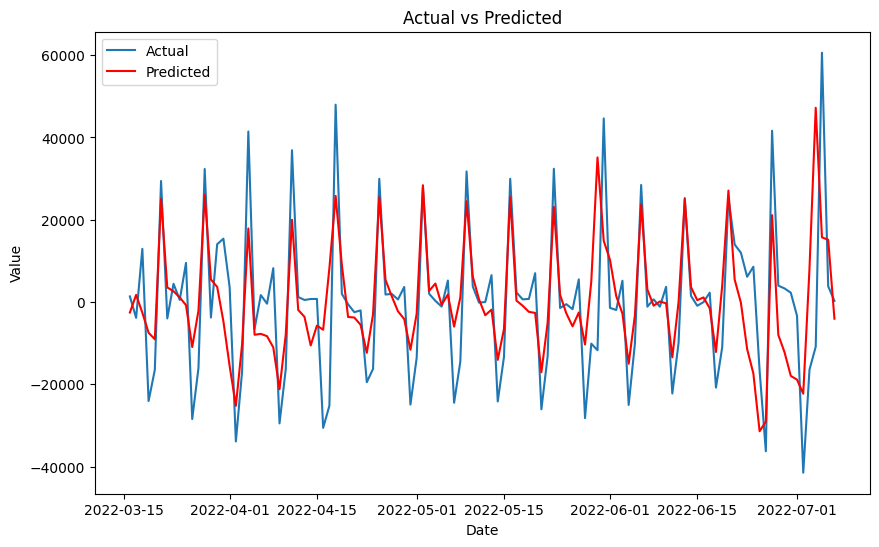

In [274]:
# get predictions
predicted = results.get_prediction(start='2022-03-16', end='2022-07-07', dynamic=False)
predicted_mean = predicted.predicted_mean

plt.figure(figsize=(10, 6))

# Plotting actual data
plt.plot(diff_test_data[diff_target_var], label='Actual')

# Plotting predicted data
plt.plot(predicted_mean, color='red', label='Predicted')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()

plt.show()

This plot shows promising results. From this, I can see that the model captures the rising and falling nature of vaccinations very well and usually at the right time. However, it does not quite reach to the extent of each rise and fall, so it is a more conservative projection. 

## Interpretation:
The ARIMAX (Autoregressive Integrated Moving Average with Exogenous Variables) model has been employed to forecast daily vaccination numbers in the United States. This model incorporates several crucial variables, including cumulative COVID-19 cases, cumulative deaths, and the percentage change in visits to transit stations and residential areas. By leveraging these factors, the model aims to predict the number of new vaccinations for a specific day.

## Performance: 
The ARIMAX model demonstrates a reasonable level of accuracy in forecasting vaccination numbers. Its predictions closely follow the actual trend, capturing most peaks, and troughs in the vaccination rates. However, it's essential to note that while the model generally captures the overall trend, it generally underestimates the magnitude of the peak.

## Utility and Recommendation: 
The ARIMAX model can serve as a valuable tool for providing insights into the expected trends in vaccination rates. Its ability to factor in COVID-19 cases, fatalities, and mobility data makes it a conservative, but reliable, predictor.

#### Practical Use Cases:
- Indicative Information: It can provide guidance on when vaccination rates might rise or fall based on the observed variables.
- Planning and Resource Allocation: Offers insight into potential high-demand periods for vaccines, aiding in logistical planning and resource allocation.
- Policy Decisions: Helps policymakers anticipate and prepare for fluctuations in vaccination rates in response to changing pandemic conditions.